## <a name="setup"></a>Global Configuration and Setting Up

In [1]:
#your working directory
pwd

u'C:\\Users\\Doug\\Documents\\GitHub\\data-scientist-exercise01\\exploration'

In [17]:
# Set the working directory as the directory where ReportMagics.py stays
# Use \\ in your path
import os
workingDir = 'C:\\Users\\Doug\\Documents\\GitHub\\data-scientist-exercise01\\exploration'
os.chdir(workingDir)

from ReportMagics import *

merged_report ='Exploratory_Report.ipynb'
%reset_all

In [18]:
%%add_conf_code_to_report
import os
workingDir = 'C:\\Users\\Doug\\Documents\\GitHub\\data-scientist-exercise01\\exploration'
os.chdir(workingDir)

conf_file = '.\\specs.yaml'
Sample_Size = 10000

export_dir = '.\\tmp\\'

In [4]:
%%add_conf_code_to_report

import pandas as pd
import numpy as np
import os
#os.chdir(workingDir)
import collections
import matplotlib
import io
import sys
import operator

import nbformat as nbf
from IPython.core.display import HTML
from IPython.display import display
from ipywidgets import interact, interactive,fixed
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import ipywidgets
import IPython
from IPython.display import clear_output
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import errno
import seaborn as sns
from string import Template
from functools import partial
from collections import OrderedDict

# Utility Classes
from ConfUtility import * 
from ReportGeneration import *
from UniVarAnalytics import *
from MultiVarAnalytics import *

%matplotlib inline

#DEBUG=0

font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

In [19]:
%%add_conf_code_to_report

if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    
def gen_report(conf_md,conf_code, md, code, filename):
    ReportGeneration.write_report(conf_md, conf_code, md, code, report_name=filename)

def translate_code_commands(cell, exported_cols, composite=False):    
    new_code_store = []
    exported_cols = [each for each in exported_cols if each!='']   
    for each in exported_cols:       
        w,x,y = each.split(',')
        with open('log.txt','w') as fout:
            fout.write('Processing call for the column {}'.format(each))
        temp=cell[0]

        new_line = temp.replace('interactive','apply').replace(
            "df=fixed(df)","df").replace("filename=fixed(filename)","'"+ReportMagic.var_files+"'").replace(
            "col1=w1","'"+w+"'").replace("col2=w2","'"+x+"'").replace("col3=w3","'"+y+"'").replace(
            "col3=fixed(w3)","'"+y+"'").replace(
            "Export=w_export","False").replace("conf_dict=fixed(conf_dict)","conf_dict")       
        new_line = new_line.replace("df,","[df,")
        new_line = new_line[:len(new_line)-1]+"])"
        new_code_store.append(new_line)        
    return new_code_store

def add_to_report(section='', task=''):
    print 'Section {}, Task {} added for report generation'.format(section ,task)

def trigger_report(widgets,export_cols_file, output_report, no_widgets=1, md_text=''):
    exported_cols = []
    with open(export_cols_file,'r') as fin:
        for each in fin:
            each = each.strip()
            if each and not each.isspace():
                exported_cols.append(each)
                
    exported_cols = list(set(exported_cols))
    conf_md, conf_code, md, code=%show_report 
    md = md_text
    cell = code
    new_code_store = translate_code_commands(cell,exported_cols)
    gen_report(conf_md,conf_code, md, new_code_store, filename=export_dir+output_report)
    
def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occured

def handle_change(value):
    w_export.value=False

def getWidgetValue(w):
    w_value = ''
    try:
        w_value = w.value
    except:
        pass    
    return w_value

def handle_export(widget, w1, w2, w3, export_filename='temp.ipynb',md_text=''):    
    print 'handle_export called'
    w1_value, w2_value, w3_value = \
        getWidgetValue(w1),getWidgetValue(w2),getWidgetValue(w3)
    st = ','.join(str(each) for each in [w1_value, w2_value, w3_value])
    with open(filename,'a') as fout:
        fout.write(st+'\n')
    trigger_report(w1_value, filename, export_filename, False, md_text=md_text)  
    
            

## <a name="read and summarize"></a> Read and Summarize the Data

### Read data and infer column types

In [20]:
%%add_conf_code_to_report

conf_dict = ConfUtility.parse_yaml(conf_file)

# Read in data from local file or SQL server
if 'DataSource' not in conf_dict:
    df=pd.read_csv(conf_dict['DataFilePath'], skipinitialspace=True)
else:
    import pyodbc
    cnxn = pyodbc.connect('driver=ODBC Driver 11 for SQL Server;server={};database={};Uid={};Pwd={}'.format(
            conf_dict['Server'], conf_dict['Database'],conf_dict['Username'],conf_dict['Password']))
    df = pd.read_sql(conf_dict['Query'],cnxn)

# Making sure that we are not reading any extra column
df = df[[each for each in df.columns if 'Unnamed' not in each]]

# Sampling Data if data size is larger than 10k
df0 = df # df0 is the unsampled data. Will be used in data exploration and analysis where sampling is not needed
         # However, keep in mind that your final report will always be based on the sampled data. 
if Sample_Size < df.shape[0]:
    df = df.sample(Sample_Size)

# change float data types
if 'FloatDataTypes' in conf_dict:   
    for col_name in conf_dict['FloatDataTypes']:
        df[col_name] = df[col_name].astype(float)      
        
# Getting the list of categorical columns if it was not there in the yaml file
if 'CategoricalColumns' not in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

# Getting the list of numerical columns if it was not there in the yaml file
if 'NumericalColumns' not in conf_dict:
    conf_dict['NumericalColumns'] = list(df.select_dtypes(include=[np.number]).columns)    

# Exclude columns that we do not need
if 'ColumnsToExclude' in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns'])-set(conf_dict['ColumnsToExclude']))
    conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns'])-set(conf_dict['ColumnsToExclude']))

# Ordering the categorical variables according to the number of unique categories
filtered_cat_columns = []
temp_dict = {}
for cat_var in conf_dict['CategoricalColumns']:
    temp_dict[cat_var] = len(np.unique(df[cat_var]))
sorted_x = sorted(temp_dict.items(), key=operator.itemgetter(0), reverse=True)
conf_dict['CategoricalColumns'] = [x for (x,y) in sorted_x]

ConfUtility.dict_to_htmllist(conf_dict,['Target','CategoricalColumns','NumericalColumns'])

### Print the first n (n=5 by default) rows of the data

In [21]:
%%add_conf_code_to_report
def custom_head(df,NoOfRows):
    return HTML(df.head(NoOfRows).style.set_table_attributes("class='table'").render())
i = interact(custom_head,df=fixed(df0), NoOfRows=ipywidgets.IntSlider(min=0, max=30, step=1, \
                                                                     value=5, description='Number of Rows'))

### Print the dimensions of the data (rows, columns)

In [22]:
%%add_conf_code_to_report
print 'The data has {} Rows and {} columns'.format(df0.shape[0],df0.shape[1])

The data has 29305 Rows and 21 columns


### Print the column names of the data

In [23]:
%%add_conf_code_to_report
col_names = ','.join(each for each in list(df.columns))
print("The column names are:" + col_names)

The column names are:id,age,workclass_id,education_level_id,education_num,marital_status_id,occupation_id,race_id,sex_id,capital_gain,capital_loss,hours_week,country_id,workclass,education_level,marital_status,occupation,race,sex,country,over_50k


### Print the column types

In [24]:
%%add_conf_code_to_report
print("The types of columns are:")
df.dtypes

The types of columns are:


id                     int64
age                    int64
workclass_id           int64
education_level_id     int64
education_num          int64
marital_status_id      int64
occupation_id          int64
race_id                int64
sex_id                 int64
capital_gain           int64
capital_loss           int64
hours_week             int64
country_id             int64
workclass             object
education_level       object
marital_status        object
occupation            object
race                  object
sex                   object
country               object
over_50k               int64
dtype: object

## <a name="individual variable"></a>Extract Descriptive Statistics of Each Column

In [25]:
%%add_conf_code_to_report
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df0.describe().T
missing_df = pd.DataFrame(df0.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df0.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df0.dtypes)
types_df.columns = ['DataType']

### Print the descriptive statistics of numerical columns

In [26]:
%%add_conf_code_to_report
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
id,29305.0,24550.842314,14092.528794,2.0,12394.0,24551.0,36763.0,48840.0,0,29305,int64
age,29305.0,38.695444,13.723411,17.0,28.0,37.0,48.0,90.0,0,74,int64
workclass_id,29305.0,4.867941,1.469535,1.0,5.0,5.0,5.0,9.0,0,9,int64
education_level_id,29305.0,11.281727,3.873239,1.0,10.0,12.0,13.0,16.0,0,16,int64
education_num,29305.0,10.081283,2.577030,1.0,9.0,10.0,12.0,16.0,0,16,int64
marital_status_id,29305.0,3.616618,1.512886,1.0,3.0,3.0,5.0,7.0,0,7,int64
occupation_id,29305.0,7.570824,4.228902,1.0,4.0,8.0,11.0,15.0,0,15,int64
race_id,29305.0,4.666542,0.847614,1.0,5.0,5.0,5.0,5.0,0,5,int64
sex_id,29305.0,1.665996,0.471649,1.0,1.0,2.0,2.0,2.0,0,2,int64
capital_gain,29305.0,1123.151203,7652.925099,0.0,0.0,0.0,0.0,99999.0,0,117,int64


### Print the descriptive statistics of categorical columns

In [27]:
%%add_conf_code_to_report
col_names = list(types_df.index) #Get all col names
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index: #Find the indices of columns in Categorical columns
    if col_names[i] in conf_dict['CategoricalColumns']:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
workclass,0,9,object
education_level,0,16,object
marital_status,0,7,object
occupation,0,15,object
race,0,5,object
sex,0,2,object
country,0,41,object
over_50k,0,2,int64


## <a name="individual variables"></a>Explore Individual Variables

### Explore the target variable

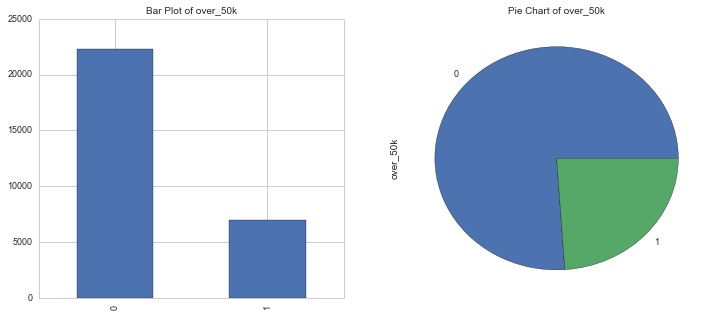

In [28]:
md_text = '## Target Variable'
filename = 'tmp/target_variables.csv'
export_filename = 'target_report2.ipynb'

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    w1_value,w2_value,w3_value = '','',''
    w1, w2, w3, w4 = None, None, None, None
    silentremove(filename)    
    w1 = widgets.Dropdown(
        options=[conf_dict['Target']],
        value=conf_dict['Target'],
        description='Target Variable:',
    )

    ReportMagic.var_files = filename
    w_export = widgets.Button(description='Export', value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)      
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)

    %reset_report
    %add_interaction_code_to_report i = interactive(TargetAnalytics.custom_barplot, df=fixed(df), \
                                                    filename=fixed(filename), col1=w1, Export=w_export)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(TargetAnalytics.custom_barplot(df=df0, filename=filename, col1=w1.value, Export=w_export))
else:
    w1_value, w2_value, w3_value = '', '', ''
    w1, w2, w3, w4 = None, None, None, None
    silentremove(filename) 
    w1 = widgets.Dropdown(
            options=[conf_dict['Target']],
            value=conf_dict['Target'],
            description='Target Variable:',
        )
    w_export = widgets.Button(description='Export', value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)

    %reset_report
    %add_interaction_code_to_report i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), filename=fixed(filename),\
                                                    col1=w1, Export=w_export)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, filename=filename, col1=w1.value, Export=w_export))

### Explore individual numeric variables and test for normality (on sampled data)

C:\Users\Doug\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


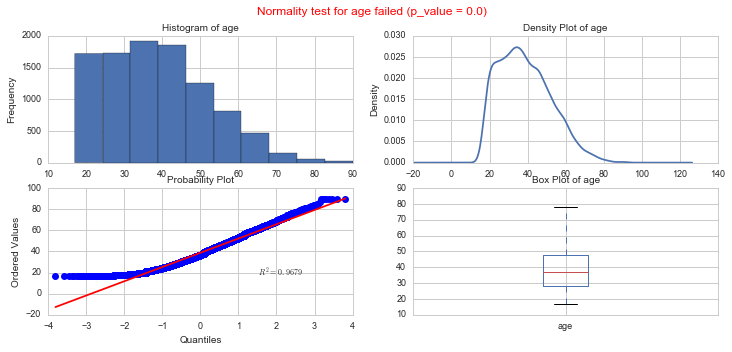

In [29]:
md_text = '## Visualize Individual Numerical Variables (on Sampled Data)'
filename = ReportMagic.var_files='tmp/numeric_variables.csv'
export_filename = 'numeric_report2.ipynb'
w1_value, w2_value, w3_value = '', '', ''
w1, w2, w3, w4 = None, None, None, None
silentremove(filename) 
w1 = widgets.Dropdown(
        options=conf_dict['NumericalColumns'],
        value=conf_dict['NumericalColumns'][0],
        description='Numeric Variable:',
    )
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), filename=fixed(filename),\
                                                col1=w1, Export=w_export)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, filename=filename, col1=w1.value, Export=w_export))

### Explore individual categorical variables (sorted by frequencies)

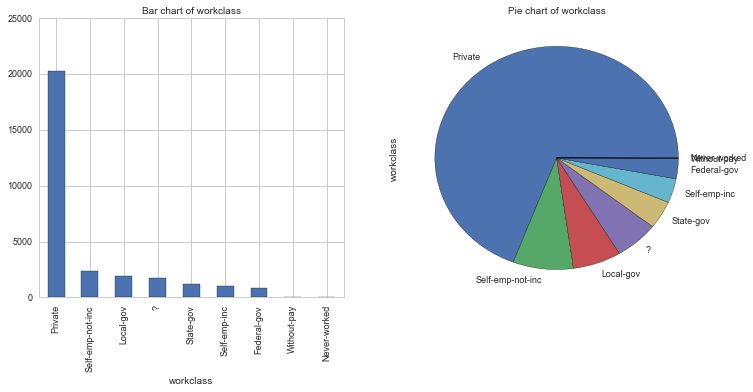

AttributeError: 'Button' object has no attribute 'value'

AttributeError: 'Button' object has no attribute 'value'

In [30]:
w_export = None
md_text = '## Visualize Individual Categorical Variables'
filename = ReportMagic.var_files='tmp/categoric_variables.csv'
export_filename = 'categoric_report2.ipynb'

w1_value, w2_value, w3_value = '', '', ''
w1, w2, w3, w4 = None, None, None, None
silentremove(filename) 
w1 = widgets.Dropdown(
    options = conf_dict['CategoricalColumns'],
    value = conf_dict['CategoricalColumns'][0],
    description = 'Categorical Variable:',
)

w_export = widgets.Button(description='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe (handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(CategoricAnalytics.custom_barplot, df=fixed(df),\
                                                filename=fixed(filename), col1=w1, Export=w_export)

hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(CategoricAnalytics.custom_barplot(df=df0, filename=filename, col1=w1.value, \
                                         Export=w_export))

## <a name="multiple variables"></a>Explore Interactions Between Variables

### <a name="rank variables"></a>Rank variables based on linear relationships with reference variable (on sampled data)

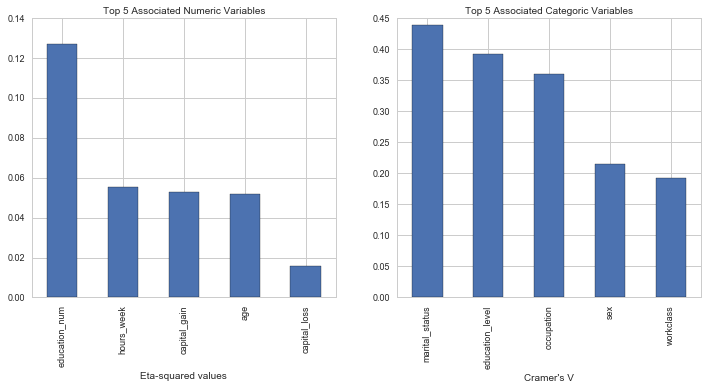

In [31]:
md_text = '## Rank variables based on linear relationships with reference variable (on sampled data)'
filename = ReportMagic.var_files='tmp/rank_associations.csv'
export_filename = 'rank_report2.ipynb'
silentremove(filename)
cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] + conf_dict['CategoricalColumns'] #Make target the default reference variable
cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)
w1.observe (handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.rank_associations, df=fixed(df), \
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3, Export=w_export)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.rank_associations(df=df, conf_dict=conf_dict, col1=w1.value, \
                                                         col2=w2.value, col3=w3.value, Export=w_export))

### <a name="two categorical"></a>Explore interactions between categorical variables

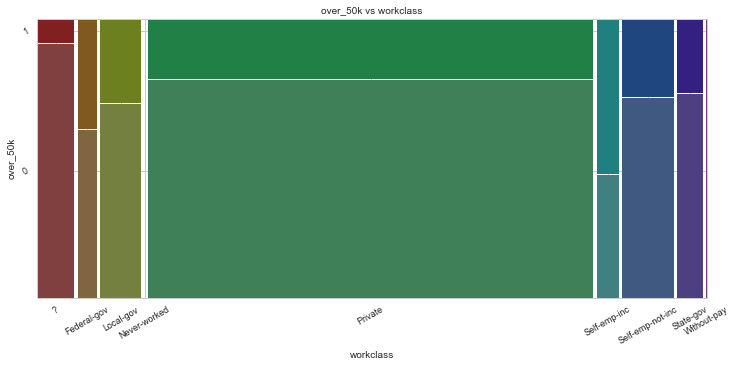

In [32]:
md_text = '## Interaction between categorical variables'
filename = ReportMagic.var_files='tmp/cat_interactions.csv'
export_filename = 'cat_interactions_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Categorical Var 2:'
)
w_export = widgets.Button(description='Export', value="Export")
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w2.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.categorical_relations, df=fixed(df), \
                                         filename=fixed(filename), col1=w1, col2=w2, Export=w_export)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.categorical_relations(df=df0, filename=filename, col1=w1.value, \
                                                             col2=w2.value, Export=w_export))

### <a name="two numerical"></a>Explore interactions between numerical variables (on sampled data)

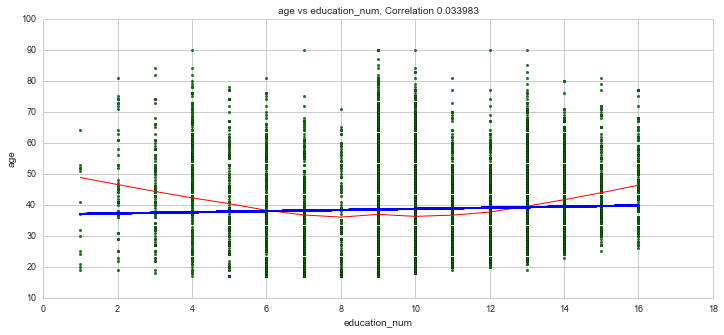

In [33]:
md_text = '## Interaction between numerical variables (on sampled data)'
filename = ReportMagic.var_files='tmp/numerical_interactions.csv'
export_filename = 'numerical_interactions_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Numerical Var 2:'
)
w_export = widgets.Button(description='Export', value="Export")
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w2.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.numerical_relations, df=fixed(df), \
                                         col1=w1, col2=w2, Export=w_export)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_relations(df, col1=w1.value, col2=w2.value, Export=w_export))

### Explore correlation matrix between numerical variables

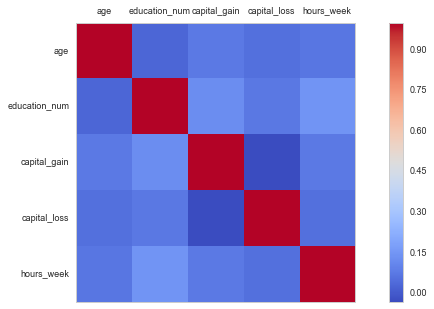

In [34]:
md_text = '## Explore correlation matrix between numerical variables'
filename = ReportMagic.var_files='tmp/numerical_corr.csv'
export_filename = 'numerical_correlations_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None
w1 = widgets.Dropdown(
    options=['pearson','kendall','spearman'],
    value='pearson',
    description='Correlation Method:'
)
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.numerical_correlation,df=fixed(df), conf_dict=fixed(conf_dict),\
                                         col1=w1, Export=w_export)

hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_correlation(df0, conf_dict=conf_dict, col1=w1.value, Export=w_export))

### <a name="numerical and categorical"></a>Explore interactions between numerical and categorical variables

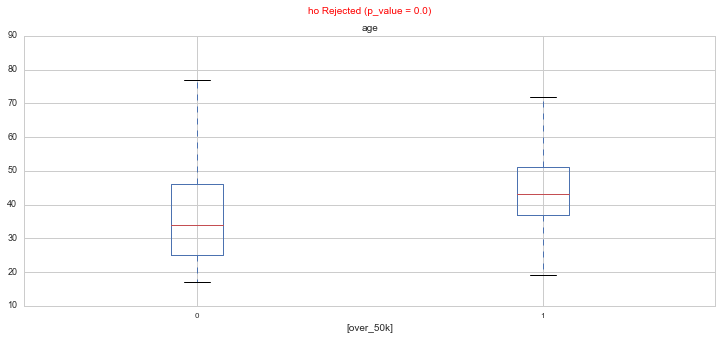

In [35]:
md_text = '## Explore interactions between numerical and categorical variables'
filename = ReportMagic.var_files = 'tmp/nc_int.csv'
export_filename = 'nc_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Variable:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Variable:'
)
w_export = widgets.Button(description='Export', value=False, options=[True, False])
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)      
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.nc_relation, df=fixed(df), \
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, \
                                                col3=fixed(w3), Export=w_export)

hbox = widgets.HBox(i.children)
display( hbox )
hbox.on_displayed(InteractionAnalytics.nc_relation(df0, conf_dict, col1=w1.value, col2=w2.value, Export=w_export))

### <a name="two numerical and categorical"></a>Explore interactions between two numerical variables and a categorical variable (on sampled data)

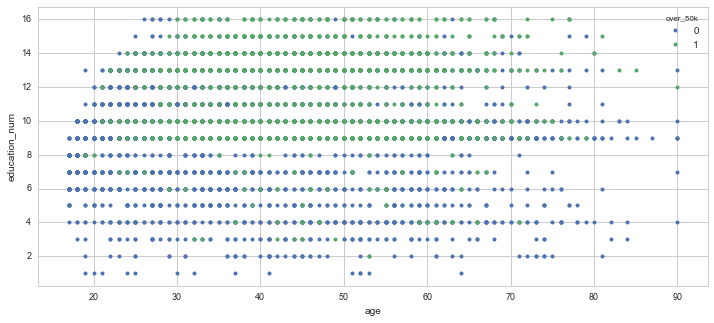

In [36]:
md_text = '## Explore interactions between two numerical variables and a categorical variable (on sampled data)'
filename = ReportMagic.var_files='tmp/nnc_int.csv'
export_filename = 'nnc_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Numerical Var 2:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
w_export = widgets.Button(description='Export', value=False, options=[True, False])
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report i = interactive(InteractionAnalytics.nnc_relation, df=fixed(df),\
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3, Export=w_export)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.nnc_relation(df, conf_dict, col1=w1.value,\
                                                    col2=w2.value, col3=w3.value, Export=w_export))

## <a name="report"></a>Generate the Data Report

In [37]:
filenames = ['target_report2.ipynb', 'numeric_report2.ipynb', 'categoric_report2.ipynb', 'rank_report2.ipynb',
           'cat_interactions_report2.ipynb', 'numerical_interactions_report2.ipynb',
             'numerical_correlations_report2.ipynb', 'nc_report2.ipynb',
             'nnc_report2.ipynb', 'numerical_pca_report2.ipynb', 'pca3d_report2.ipynb'
           ]

def merge_notebooks():
    merged = None
    for fname in filenames:
        try:
            print 'Processing {}'.format(export_dir+fname)
            with io.open(export_dir+fname, 'r', encoding='utf-8') as f:
                nb = nbf.read(f, as_version=4)
            if merged is None:
                merged = nb
            else:
                merged.cells.extend(nb.cells[2:])
        except:
            print 'Warning: Unable to find the file', export_dir+'//'+fname, ', continue...'
    if not hasattr(merged.metadata, 'name'):
        merged.metadata.name = ''
    merged.metadata.name += "_merged"
    with open(merged_report, 'w') as f:
        nbf.write(merged, f)

def gen_merged_report(b):
    merge_notebooks()
    
button=widgets.Button(description='Generate Final Report')
button.on_click(gen_merged_report)
display(button)

## <a name="show hide codes"></a>Show/Hide the Source Codes

In [38]:
# Provide the path to the yaml file relative to the working directory
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
//$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')